### Access Files in Drive

---

In [ ]:
from google.colab import drive 
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


### Import required libraries and necessary packages

In [8]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img

from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

### Load The data

In [9]:
#The path of our data on drive
data_dir =  r'C:/Users/Meghana/Downloads/Project_work/COVID-19-Detection-From-X-Ray-master (2)/COVID-19-Detection-From-X-Ray-master/final_dataset'
 
#Loading Data
data = load_files(data_dir)

In [10]:
folders=os.listdir("C:/Users/Meghana/Downloads/Project_work/COVID-19-Detection-From-X-Ray-master (2)/COVID-19-Detection-From-X-Ray-master/final_dataset")
print(folders)

['COVID', 'non-COVID']


>As you can see, our data set, contains two folders, **Covid-19** which contains X-ray images of people caught up with the virus, the **No_findings** which contains X-ray images of normal people

In [11]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  C:/Users/Meghana/Downloads/Project_work/COVID-19-Detection-From-X-Ray-master (2)/COVID-19-Detection-From-X-Ray-master/final_dataset\COVID\Covid (682).png
Target labels -  0
Number of training files :  2481
Number of training targets :  2481


### Convert images to arrays

In [12]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224 
    # Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        # update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))
 
# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(2481, 224, 224, 3)
First training item :  [[[235. 235. 235.]
  [235. 235. 235.]
  [234. 234. 234.]
  ...
  [233. 233. 233.]
  [233. 233. 233.]
  [233. 233. 233.]]

 [[235. 235. 235.]
  [235. 235. 235.]
  [234. 234. 234.]
  ...
  [233. 233. 233.]
  [233. 233. 233.]
  [233. 233. 233.]]

 [[234. 234. 234.]
  [234. 234. 234.]
  [234. 234. 234.]
  ...
  [233. 233. 233.]
  [233. 233. 233.]
  [233. 233. 233.]]

 ...

 [[228. 228. 228.]
  [228. 228. 228.]
  [229. 229. 229.]
  ...
  [228. 228. 228.]
  [228. 228. 228.]
  [229. 229. 229.]]

 [[229. 229. 229.]
  [230. 230. 230.]
  [227. 227. 227.]
  ...
  [229. 229. 229.]
  [230. 230. 230.]
  [230. 230. 230.]]

 [[229. 229. 229.]
  [230. 230. 230.]
  [227. 227. 227.]
  ...
  [229. 229. 229.]
  [230. 230. 230.]
  [230. 230. 230.]]]


#### **Few Take Aways**
#### Note that the shape of training data is **(625, 224, 224, 3)**
#####  
 
-   **625** is the **number** of training items or files,
-   **(224,224)** is the **target size** or image size provided while loading image
-   **3** refers to the **depth** for colored images ( RGB channels ).

### Take a look at some pictures

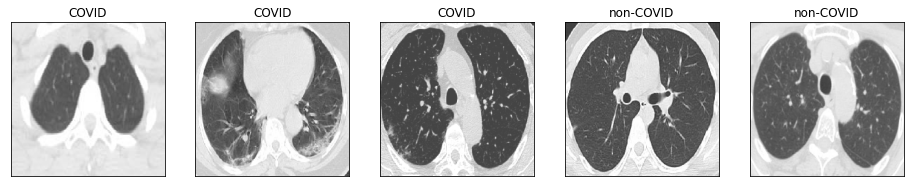

In [13]:
# Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [14]:
"""
   After that data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

2

In [15]:
y

array([0, 0, 0, ..., 0, 0, 1])

In [16]:
""" 
let's converts a class vector (integers) to binary class matrix by performing the 
one-hot encoding on the labels
"""
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([1., 0.], dtype=float32)

In [17]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  1984
The validation Data Shape  249
The test Data Shape  248


In [18]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


> **(224, 224, 3)** refers to the shape of the data (images) that will be fed into our CNN

---

### **CNN Implementation**

In [19]:
# load the VGG16 model without the final layers(include_top=False)
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
print("Base Model loaded !")
 
"""
  Loop over all layers in the base model and freeze them so they will
  not be updated during the first training process
"""
for layer in baseModel.layers:
    layer.trainable = False
    
baseModel.summary()

Base Model loaded !
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 5

In [20]:
# In the summary above of our base model, trainable params is 0
""" Now, let's create a headModel to put on top of the base model
    (we are not freezing any layers of this model) 
"""
headModel = Sequential()
headModel.add(AveragePooling2D(pool_size=(4,4), input_shape=baseModel.output_shape[1:], name="AveragePooling2"))
headModel.add(Flatten( name ="Flatten"))
headModel.add(Dense(64, activation ="relu"))
headModel.add(Dropout(0.5, name="Dropout"))
headModel.add(Dense(no_of_classes, activation="softmax"))

headModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AveragePooling2 (AveragePoo  (None, 1, 1, 512)        0         
 ling2D)                                                         
                                                                 
 Flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 32,962
Trainable params: 32,962
Non-trainable params: 0
____________________________________________________

In [21]:
# In the summary above of our base model, trainable params is 32, 962
""" Let's build the final model where we add the top_model on top of base_model.
    So, we will place the head Model on the top of the base Model. Therefore, this 
    'Model' will become the actual model we will train
"""
Model = Sequential()
Model.add(baseModel)
Model.add(headModel)
 
# I can check the summary of the final Model which we created by using the line of code below.
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential (Sequential)     (None, 2)                 32962     
                                                                 
Total params: 14,747,650
Trainable params: 32,962
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
lr = 1e-3
epochs = 50
bs = 8
optimizer = Adam(lr = lr, decay= lr/epochs)
Model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\Meghana\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


---

In [24]:
# Time to train our model !
epochs = 100
 
# Initialize the training data augmentation object
train_datagen = ImageDataGenerator(
        rotation_range=15,
        fill_mode ="nearest")
 
checkpointer = ModelCheckpoint(filepath = "/gdrive/My Drive/CDX_Best.h5", save_best_only = True, verbose=1)
start = time.time()
 
# let's get started !
 
history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = 60,

                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer])
 
end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

C:\Users\Meghana\AppData\Local\Temp\ipykernel_19104\4150513627.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 0.6112 - accuracy: 0.6750WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 31 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_loss improved from inf to 0.57719, saving model to /gdrive/My Drive\CDX_Best.h5
60/60 [==============================] - 93s 2s/step - loss: 0.6112 - accuracy: 0.6750 - val_loss: 0.5772 - val_accuracy: 0.7631
Epoch 2/100
60/60 [==============================] - 95s 2s/step - loss: 0.5940 - accuracy: 0.7000
Epoch 3/100
60/60 [==============================] - 96s 2s/step - loss: 0.5739 - accuracy: 0.7104
Epoch 4/100
60/60 [==============================] - 105s 2s/step - loss: 0.5724 - accuracy: 0.6917
Epoch 5/100
60/60 [==============================] - 57s 956ms/step - loss: 0.5404 - accuracy: 0.7271
Epoch 6/100
60/60

**==> After training the model, we will be able to see the spectacular and the impressive performance reached ! :)**

---

### **Evaluation**
> The result of the script below shows the accuracy and loss of the test, using test data of course !

In [25]:
(eval_loss, eval_accuracy) = Model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

31/31 - 20s - loss: 0.3453 - accuracy: 0.8508 - 20s/epoch - 649ms/step
Accuracy: 85.08%
Loss: 0.3452765643596649


### Accuracy and Loss graphs

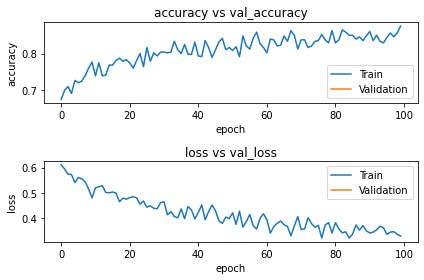

In [26]:
# Let's visualize the train/validation loss and accuracy wrt epochs
 
import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # Summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # Summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

8/8 [==============================] - 20s 2s/step


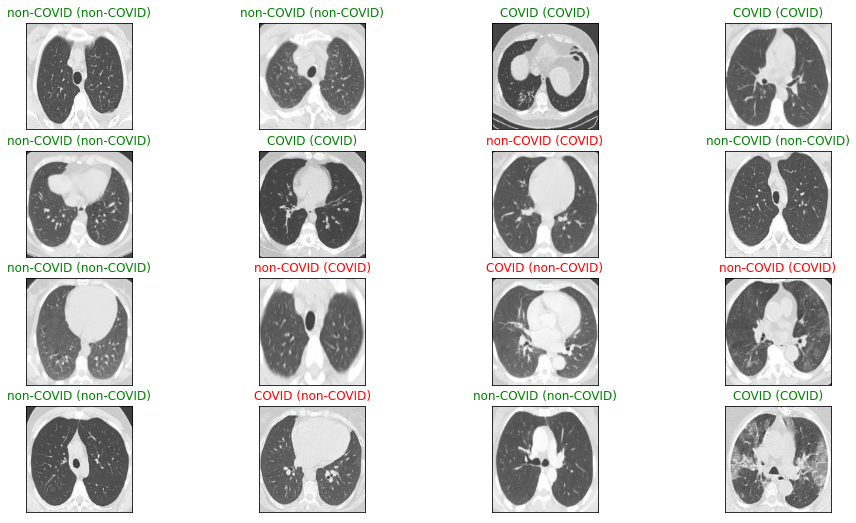

In [27]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# Plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))
 
visualize_pred(Model.predict(X_test))

### Confusion Matrix
> Please note that, **_0_ and _1_ values represent _Covid-19_ and _No_findigs_ respectively**  .

8/8 [==============================] - 20s 3s/step


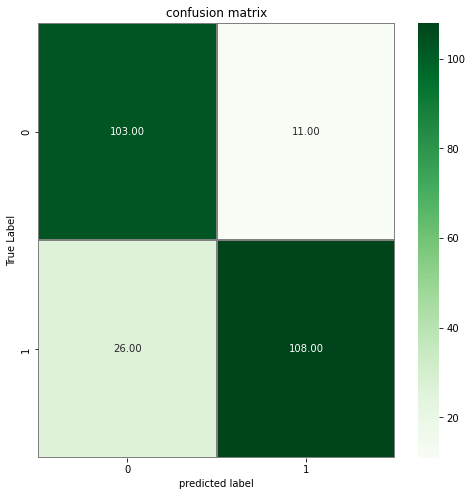

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

> You can check the classification report below for more information !

In [29]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

       COVID       0.80      0.90      0.85       114
   non-COVID       0.91      0.81      0.85       134

    accuracy                           0.85       248
   macro avg       0.85      0.85      0.85       248
weighted avg       0.86      0.85      0.85       248



### Loading the model
> Here we're gonna load our best model trained befor, then make some predictions with it !

In [31]:
my_model=keras.models.load_model('/gdrive/My Drive/CDX_Best.h5')

8/8 [==============================] - 20s 3s/step


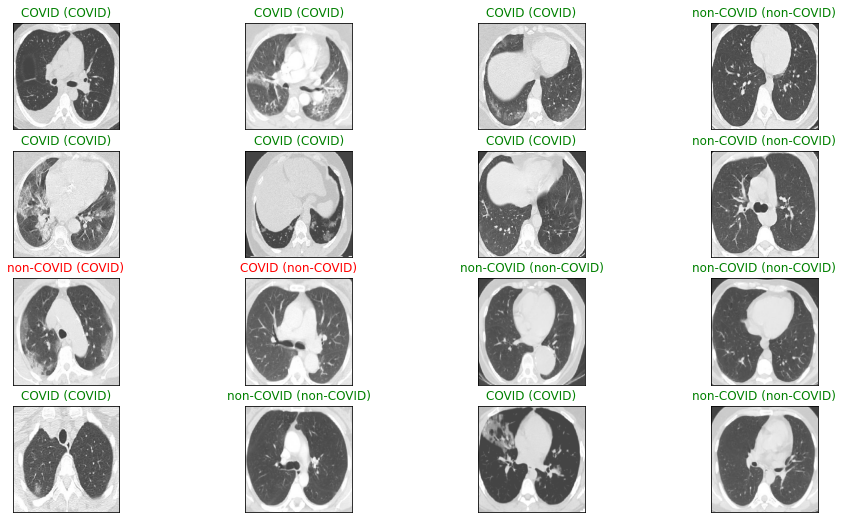

In [32]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))